In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [127]:
from scipy.stats import norm

def make(n_samples, nuisance=0.):
    y = np.zeros(n_samples).astype(np.int)
    y[n_samples // 2:] = 1
    
    X0 = np.hstack([norm(0, 1).rvs(n_samples // 2).reshape(-1, 1),
                    norm(0, 1).rvs(n_samples // 2).reshape(-1, 1)])
    X1 = np.hstack([norm(1, 1).rvs(n_samples // 2).reshape(-1, 1),
                    norm(nuisance, 1).rvs(n_samples // 2).reshape(-1, 1)])

    return np.vstack([X0, X1]), y

In [131]:
X0, y0 = make(5000, nuisance=0)
X1, y1 = make(5000, nuisance=6)
X = np.vstack([X0, X1])
y = np.concatenate([y0, y1])
z = np.zeros(len(X))
z[len(X0):] = 1

In [132]:
X.shape, y.shape, z.shape

((10000, 2), (10000,), (10000,))

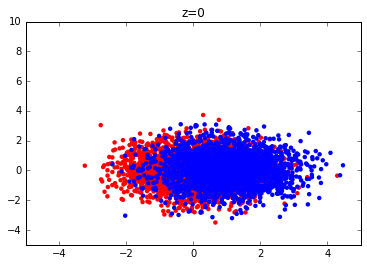

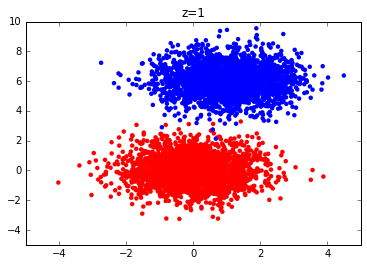

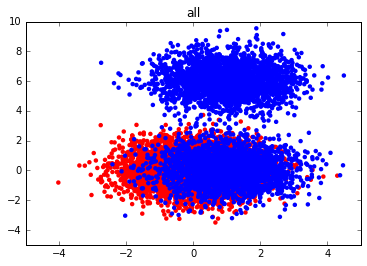

In [133]:
plt.title("z=0")
plt.scatter(X0[y0==0, 0], X0[y0==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X0[y0==1, 0], X0[y0==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

plt.title("z=1")
plt.scatter(X1[y1==0, 0], X1[y1==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X1[y1==1, 0], X1[y1==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

plt.title("all")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()

In [217]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model

inputs = Input(shape=(X.shape[1],))
Dx = Dense(24, activation="relu")(inputs)
Dx = Dense(24, activation="relu")(Dx)
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])

Rx = D(inputs)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(24, activation="relu")(Rx)
Rx = Dense(1, activation="sigmoid")(Rx)
R = Model(input=[inputs], output=[Rx])

In [218]:
from keras.optimizers import Adam, SGD

def make_loss_D(c):
    def loss_D(y_true, y_pred):
        y_true = y_true.ravel()
        y_pred = y_pred.ravel()
        return c * ((1.0 - y_true) * (K.log(1.0 - y_pred)) + (y_true) * (K.log(y_pred))) 

    return loss_D

def make_loss_R(c):
    def loss_R(z_true, z_pred):
        z_true = z_true.ravel()
        z_pred = z_pred.ravel()
        return c * ((1.0 - z_true) * (K.log(1.0 - z_pred)) + (z_true) * (K.log(z_pred)))
    
    return loss_R

opt_DRf = SGD(lr=10e-4, momentum=0.1)
DRf = Model(input=[inputs], output=[D(inputs), R(inputs)])
DRf.compile(loss=[make_loss_D(c=-1.0), 
                  make_loss_R(c=10.0)],   # compare with c=0.0, ie. when no there is no adversary
            optimizer=opt_DRf)

opt_DfR = SGD(lr=10e-3, momentum=0.1)
DfR = Model(input=[inputs], output=[R(inputs)])
DfR.compile(loss=[make_loss_R(c=-1.0)], 
            optimizer=opt_DfR)

In [219]:
DRf.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_66 (Model)                 (None, 1)             697         input_16[0][0]                   
____________________________________________________________________________________________________
model_67 (Model)                 (None, 1)             1370        input_16[0][0]                   
Total params: 2067
____________________________________________________________________________________________________


In [220]:
DfR.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 2)             0                                            
____________________________________________________________________________________________________
model_67 (Model)                 (None, 1)             1370        input_16[0][0]                   
Total params: 1370
____________________________________________________________________________________________________


In [221]:
DRf.predict(X[:3])

[array([[ 0.45147878],
        [ 0.32870042],
        [ 0.40448955]], dtype=float32), array([[ 0.50634062],
        [ 0.50461644],
        [ 0.50568074]], dtype=float32)]

In [222]:
DfR.predict(X[:3])

array([[ 0.50634062],
       [ 0.50461644],
       [ 0.50568074]], dtype=float32)

In [223]:
# Pretraining
D.trainable = False
R.trainable = True
DfR.fit(X, z, nb_epoch=100)

Epoch 1/100
10000/10000 [==============================] - 0s - loss: 0.6932     
Epoch 2/100
10000/10000 [==============================] - 0s - loss: 0.6910     
Epoch 3/100
10000/10000 [==============================] - 0s - loss: 0.6886     
Epoch 4/100
10000/10000 [==============================] - 0s - loss: 0.6862     
Epoch 5/100
10000/10000 [==============================] - 0s - loss: 0.6835     
Epoch 6/100
10000/10000 [==============================] - 0s - loss: 0.6805     
Epoch 7/100
10000/10000 [==============================] - 0s - loss: 0.6764     
Epoch 8/100
10000/10000 [==============================] - 0s - loss: 0.6716     
Epoch 9/100
10000/10000 [==============================] - 0s - loss: 0.6663     
Epoch 10/100
10000/10000 [==============================] - 0s - loss: 0.6601     
Epoch 11/100
10000/10000 [==============================] - 0s - loss: 0.6512     
Epoch 12/100
10000/10000 [==============================] - 0s - loss: 0.6415     
Epoch 13/100


In [224]:
from IPython import display

def plot_losses(i, losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())

    plt.title("iteration = %d" % i)
    
    for label, values in losses.items():
        plt.plot(range(len(values)), values, label=label)
        
    plt.legend(loc="best")
    plt.show()

In [225]:
losses = {"L_d": [], "L_r": [], "L_d - L_r": []}

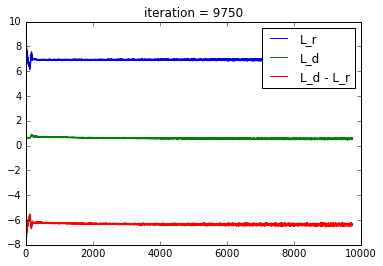

In [226]:
batch_size = 128

for i in range(10000):
    if i % 250 == 0:
        plot_losses(i, losses)
    
    # Fit D
    D.trainable = True
    R.trainable = False
    indices = np.random.permutation(len(X))[:batch_size]
    l = DRf.train_on_batch(X[indices], [y[indices], z[indices]])
    
    losses["L_d - L_r"].append(l[0][None][0])
    losses["L_d"].append(l[1][None][0])
    losses["L_r"].append(-l[2][None][0])
    
    # Fit R
    D.trainable = False
    R.trainable = True
    
    for j in range(10):
        indices = np.random.permutation(len(X))[:batch_size]
        DfR.train_on_batch(X[indices], z[indices])

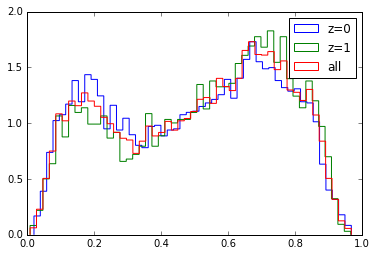

In [227]:
plt.hist(D.predict(X[z==0]), bins=50, normed=1, histtype="step", label="z=0")
plt.hist(D.predict(X[z==1]), bins=50, normed=1, histtype="step", label="z=1")
plt.hist(D.predict(X), bins=50, normed=1, histtype="step", label="all")
plt.legend()
plt.show()

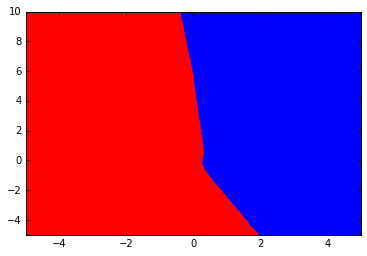

In [228]:
X_test = np.random.rand(100000, 2)
X_test[:, 0] *= 10. 
X_test[:, 0] -= 5.
X_test[:, 1] *= 15. 
X_test[:, 1] -= 5.
y_pred = D.predict(X_test).ravel()

plt.scatter(X_test[y_pred < 0.5, 0], X_test[y_pred < 0.5, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X_test[y_pred > 0.5, 0], X_test[y_pred > 0.5, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-5, 5)
plt.ylim(-5, 10)
plt.show()